In [290]:
import torch

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

In [292]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [293]:
bairros = pd.read_csv("https://raw.githubusercontent.com/chandez/Estados-Cidades-IBGE/master/csv/bairros.csv")
bairros

,Id,Codigo,Nome,Uf
0,1,1100015001,Centro - Alta Floresta D'Oeste,RO
1,2,1100015002,Liberdade - Alta Floresta D'Oeste,RO
2,3,1100015003,Cidade Alta - Alta Floresta D'Oeste,RO
3,4,1100015004,Santa Felicidade - Alta Floresta D'Oeste,RO
4,5,1100015005,Princesa Isabel - Alta Floresta D'Oeste,RO
...,...,...,...,...
14315,14316,5218300009,Setor Mãe Bela - Posse,GO
14316,14317,5218300010,Setor Buenos Aires - Posse,GO
14317,14318,5218300011,Cafelândios - Posse,GO
14318,14319,5218300012,Vale do Amanhecer - Posse,GO


In [294]:
bairros["tokens"] = bairros["Nome"].str.split()
bairros

,Id,Codigo,Nome,Uf,tokens
0,1,1100015001,Centro - Alta Floresta D'Oeste,RO,"[Centro, -, Alta, Floresta, D'Oeste]"
1,2,1100015002,Liberdade - Alta Floresta D'Oeste,RO,"[Liberdade, -, Alta, Floresta, D'Oeste]"
2,3,1100015003,Cidade Alta - Alta Floresta D'Oeste,RO,"[Cidade, Alta, -, Alta, Floresta, D'Oeste]"
3,4,1100015004,Santa Felicidade - Alta Floresta D'Oeste,RO,"[Santa, Felicidade, -, Alta, Floresta, D'Oeste]"
4,5,1100015005,Princesa Isabel - Alta Floresta D'Oeste,RO,"[Princesa, Isabel, -, Alta, Floresta, D'Oeste]"
...,...,...,...,...,...
14315,14316,5218300009,Setor Mãe Bela - Posse,GO,"[Setor, Mãe, Bela, -, Posse]"
14316,14317,5218300010,Setor Buenos Aires - Posse,GO,"[Setor, Buenos, Aires, -, Posse]"
14317,14318,5218300011,Cafelândios - Posse,GO,"[Cafelândios, -, Posse]"
14318,14319,5218300012,Vale do Amanhecer - Posse,GO,"[Vale, do, Amanhecer, -, Posse]"


In [295]:
tokens = bairros["tokens"].values
vocab = sorted(list(set(sum(bairros["tokens"].values, []))))
vocab[15:20]

['(S-10', '(S-8', '(S-9', '-', '/']

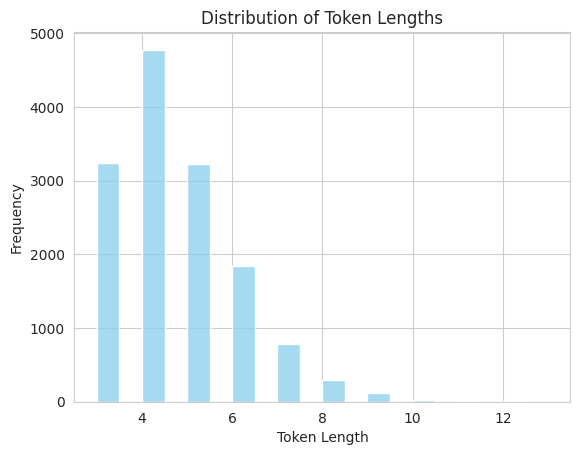

In [296]:
import matplotlib.pyplot as plt

token_lengths = [len(t) for t in tokens]

sns.set_style("whitegrid")

sns.histplot(token_lengths, bins=20,  color='skyblue')

plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.show()

In [297]:
# build the vocabulary of characters and mappings to/from integers
stoi = {s:i+1 for i,s in enumerate(vocab)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [298]:
# build the dataset
block_size = 6 # context length: how many characters do we take to predict the next one?
vocab_size = len(vocab)

def build_dataset(tokens):
  X, Y = [], []
  for w in tokens:

    context = [0] * block_size
    for ch in w + ['.']:
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [299]:
batch_size = 16

In [300]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens
        self.X, self.Y = build_dataset(self.tokens)
        self.X = self.X.to(device)
        self.Y = self.Y.to(device)
    
    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Assuming tokens is already shuffled
random.seed()
random.shuffle(tokens)

n1 = int(0.8 * len(tokens))
n2 = int(0.9 * len(tokens))

# Set the device you want to use (e.g., 'cuda' for GPU or 'cpu' for CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = CustomDataset(tokens[:n1])
dev_dataset   = CustomDataset(tokens[n1:n2])
test_dataset  = CustomDataset(tokens[n2:])

# Example of DataLoader creation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([63721, 6]) torch.Size([63721])
torch.Size([8016, 6]) torch.Size([8016])
torch.Size([7895, 6]) torch.Size([7895])


In [301]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self,embedding_dim=30):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(vocab_size, embedding_dim),nn.Tanh())
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(embedding_dim * block_size, 512),
            nn.BatchNorm1d(512),  # Batch normalization layer
            nn.ReLU(),
        )
        self.decoder = nn.Linear(512, vocab_size)

    def forward(self, x):
        # Perform one-hot encoding
        x = torch.nn.functional.one_hot(x, num_classes=self.encoder[0].in_features).float()
        # Pass through encoder layer
        x = self.encoder(x)
        x = x.view(x.shape[0],-1)
        x = self.linear_relu_stack(x)
        logits = self.decoder(x)
        return logits

In [302]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []  # Collect losses for plotting
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())  # Append current loss to the list

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X) + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return np.log(losses)  # Return losses for plotting

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return np.log(test_loss)

In [303]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=6016, out_features=30, bias=True)
    (1): Tanh()
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=180, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): Linear(in_features=512, out_features=6016, bias=True)
)

In [304]:
learning_rate = 1e-3

In [305]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR by a factor of 0.1 every 5 epochs

train_losses = []  # Collect training losses for plotting
dev_losses = []    # Collect dev (validation) losses for plotting

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    dev_loss = test_loop(dev_loader, model, loss_fn)
    train_losses.extend(train_loss)  # Extend train_losses list with losses from this epoch
    dev_losses.append(dev_loss)      # Append dev_loss to dev_losses list
    scheduler.step()  # Step the scheduler to update the learning rate

print("Done!")

Epoch 1
-------------------------------
loss: 8.776143  [   16/11456]


loss: 5.696325  [ 1616/11456]
loss: 6.958888  [ 3216/11456]
loss: 3.748686  [ 4816/11456]
loss: 4.493782  [ 6416/11456]
loss: 4.426299  [ 8016/11456]
loss: 3.418755  [ 9616/11456]
loss: 3.646348  [11216/11456]
Test Error: 
 Accuracy: 43.9%, Avg loss: 4.231139 

Epoch 2
-------------------------------
loss: 2.330014  [   16/11456]
loss: 4.670491  [ 1616/11456]
loss: 3.702593  [ 3216/11456]
loss: 3.161109  [ 4816/11456]
loss: 3.504338  [ 6416/11456]
loss: 5.801806  [ 8016/11456]
loss: 2.653826  [ 9616/11456]
loss: 3.073145  [11216/11456]
Test Error: 
 Accuracy: 46.4%, Avg loss: 4.281561 

Epoch 3
-------------------------------
loss: 2.454165  [   16/11456]
loss: 2.946674  [ 1616/11456]
loss: 1.998492  [ 3216/11456]
loss: 2.571924  [ 4816/11456]
loss: 2.968751  [ 6416/11456]
loss: 3.502469  [ 8016/11456]
loss: 2.718963  [ 9616/11456]
loss: 1.756172  [11216/11456]
Test Error: 
 Accuracy: 46.4%, Avg loss: 4.758034 

Epoch 4
-------------------------------
loss: 2.244092  [   16/11456]
loss

In [306]:
batches_per_epoch = len(train_loader)  # Total number of batches per epoch
batch_step = batches_per_epoch // epochs  # Number of batches to process per epoch

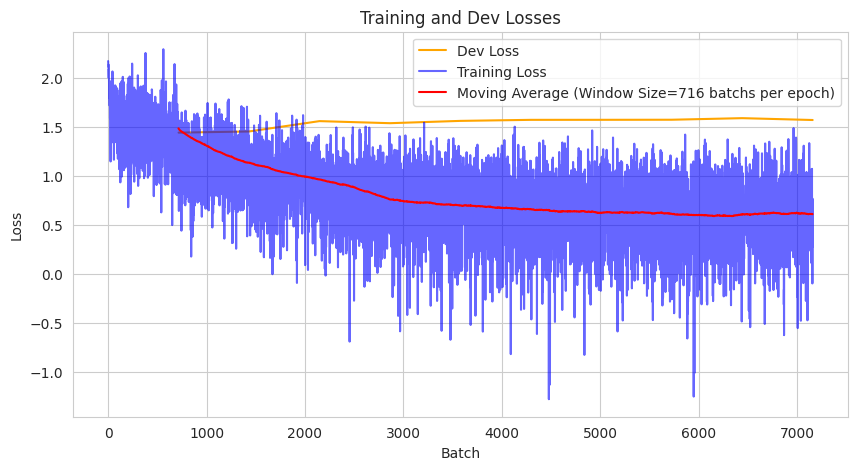

In [307]:
# Plot training and dev losses
plt.figure(figsize=(10, 5))

    
plt.plot(np.arange(batches_per_epoch, epochs * batches_per_epoch + 1, batches_per_epoch), dev_losses, label='Dev Loss', color='orange')

plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss', color='blue',alpha=0.6)

# Calculate moving average with window size
window_size = batches_per_epoch
moving_avg = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
plt.plot(np.arange(window_size-1, len(train_losses)), moving_avg, label=f'Moving Average (Window Size={window_size} batchs per epoch)', color='red')


plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training and Dev Losses')
plt.legend()
plt.show()

In [308]:
loss = test_loop(dev_loader, model, loss_fn)

Test Error: 
 Accuracy: 46.9%, Avg loss: 4.812389 



In [309]:
def generate(context_,n = 10):
    model.eval()
    # Sample from the model
    for _ in range(n):
        out = []
        context = context_ # initialize with all ...
        while True:
            # Move context tensor to the appropriate device
            context_tensor = torch.tensor(context).to(device).reshape(-1, block_size)
            
            # Forward pass through the model
            logits = model(context_tensor)
            
            # Apply softmax to logits to get probabilities
            probs = nn.Softmax(dim=1)(logits).to("cpu")
            
            # Generate a sample using multinomial sampling
            ix = torch.multinomial(probs, num_samples=1).item()
            
            # Update context
            context = context[1:] + [ix]
            
            # Append the sampled index to the output
            out.append(ix)
            
            # If the sampled index is 0, break the loop
            if ix == 0:
                break
        
        # Print the sampled sequence
        word = ' '.join(itos[i] for i in context_ if i) + " " + ' '.join(itos[i] for i in out[:-1])
        word = word.replace(". ","")
        print(word)

context = [0] * block_size  # initialize with all ...
generate(context)

 Subsetor Oeste - Paulista - O-1 - Ribeirão Preto
 Região Urbana Homogênea XXIV - Poços de Caldas
 Limoeiro - Cariacica
 Andorinhas - Praia Grande
 Parque Vila Serra - Patos de Minas
 Próspero - Planalto
 Azaléia - Caxias do Sul
 Tabajara - Boa Vista
 Fruteira - Laurentino
 Parque Santa São Francisco - Galli


In [310]:
context = [0] * block_size  # initialize with all ...
context[-1] = stoi["Santa"]
generate(context)

Santa Rita - Lauro Muller
Santa Maria II
Santa Fé - Campo Grande
Santa Clara - Farroupilha
Santa Rita - Itabirito
Santa Clara - Encantado
Santa Rita - Osasco
Santa Cecília - Pires do Rio
Santa Luzia - Branco
Santa Catarina - Campo Mourão


In [311]:
context = [0] * block_size  # initialize with all ...
context[-1] = stoi["Centro"]
generate(context)

Centro - Canindé
Centro - Não-Me-Toque
Centro - Patrocínio


Centro - Araricá
Centro - Boa Viagem -
Centro - Soure
Centro Comercial - Ponte Nova
Centro - Osasco
Centro - José Viana
Centro - Manoel Russas


In [312]:
context = [0] * block_size  # initialize with all ...
context[-2] = stoi["Vila"]
context[-1] = stoi["do"]
generate(context)

Vila do Sul - Embu das Artes
Vila do - - Cuiabá
Vila do Grande - Angra dos Reis
Vila do da - Catanduva


Vila do dos de - Santa Machado
Vila do Costa - Belo Horizonte
Vila do São José - Nova
Vila do Armour - São Gonçalo
Vila do II - Cuiabá
Vila do Sul da Bebedouro - Balneário Camboriú


In [333]:
from sklearn.manifold import TSNE

# Set your model to evaluation mode
model.eval()

# Initialize lists to store embeddings and corresponding labels
embeddings = []
labels = []

# Iterate through the data loader to obtain embeddings and labels
for data, target in dev_loader:
    # Forward pass through the model to obtain embeddings
    with torch.no_grad():
        x = torch.nn.functional.one_hot(data, num_classes=model.encoder[0].in_features).float()
        x = model.encoder(x)
        x = x.view(x.shape[0],-1)
    embeddings.append(x.cpu())
    labels.append(target.cpu())

# Concatenate embeddings and labels
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

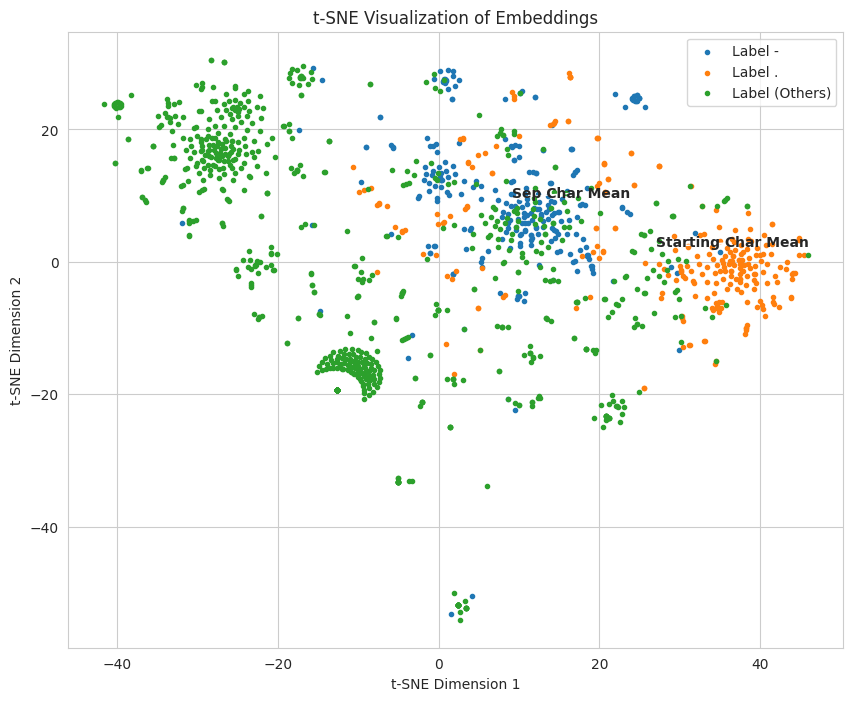

In [365]:
# Plot the embeddings
plt.figure(figsize=(10, 8))

from collections import Counter
c = Counter(labels)

i_special_words = [i[0] for i in c.most_common(2)]

# i_special_words = [stoi[i] for i in special_words]
for i in i_special_words:
    plt.scatter(embeddings_2d[labels == i, 0], embeddings_2d[labels == i, 1], label=f'Label {itos[i]}', marker='.')


idx = ~np.isin(labels, i_special_words)
plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label='Label (Others)', marker='.')



# Assuming embeddings_2d and labels are NumPy arrays
label_0_mean_x = embeddings_2d[labels == 19, 0].mean()
label_0_mean_y = embeddings_2d[labels == 19, 1].mean()

plt.annotate('Sep Char Mean', 
             xy=(label_0_mean_x, label_0_mean_y), 
             xytext=(label_0_mean_x + 0.1, label_0_mean_y + 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10,
            #  fontstyle='italic',
             fontweight='bold')


# Assuming embeddings_2d and labels are NumPy arrays
label_0_mean_x = embeddings_2d[labels == 0, 0].mean()
label_0_mean_y = embeddings_2d[labels == 0, 1].mean()

plt.annotate('Starting Char Mean', 
             xy=(label_0_mean_x, label_0_mean_y), 
             xytext=(label_0_mean_x + 0.1, label_0_mean_y + 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10,
            #  fontstyle='italic',
             fontweight='bold')

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [316]:
path = 'models/MPL01.pth'
torch.save(model.state_dict(), path)